In [63]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from data_import.weather_data import get_weather_data
from data_import.consumption_data import get_consumption_data

##### data import

In [2]:
data = get_weather_data(2021, 2026, "./data/weather_data.csv")
weather_data_by_time = data.pivot_table(
    index="Tid(norsk normaltid)",
    values=["Nedbør (1 t)",	"Lufttemperatur", "Lufttrykk i stasjonsnivå", "Vindretning", "Middelvind"],
    columns="Navn"
)

In [3]:
consumption_df = get_consumption_data("NO5", start_year = 2021, end_year = 2026, save_path="./data/consumption_data.csv")

consumption_by_group = consumption_df.pivot_table(
    index="startTime",
    columns="consumptionGroup",
    values="quantityKwh"
    ).sort_index()

5


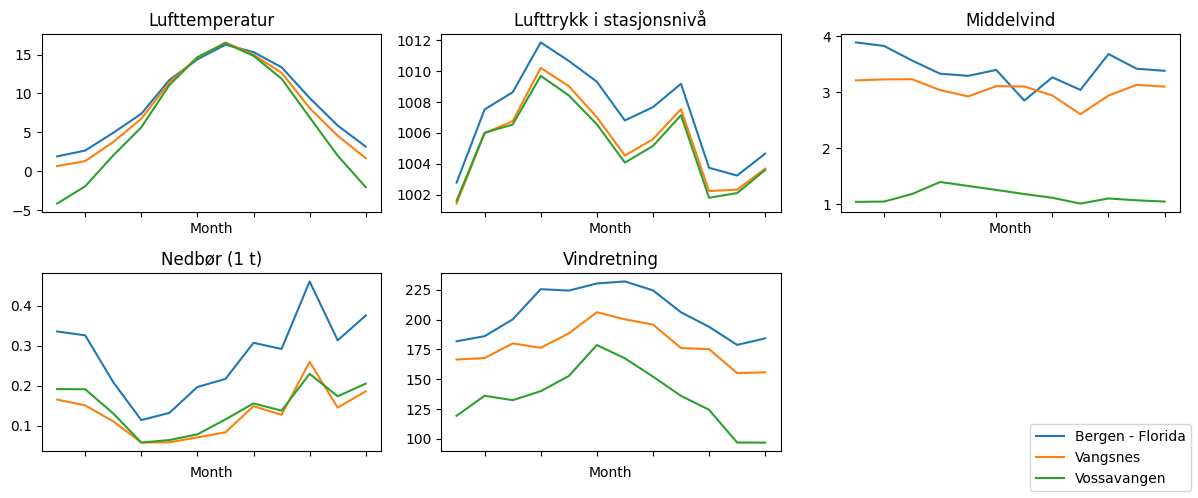

In [4]:
monthly_data = weather_data_by_time.groupby(weather_data_by_time.index.month).mean()
measurements = monthly_data.columns.levels[0]

fig, ax = plt.subplots(
    nrows=len(measurements)//2,
    ncols=3,
    figsize=(4 * (len(measurements)//2+1), 5),
    sharex=True
)
print(len(measurements))

for i, measurement in enumerate(measurements):
    ax[i//3, i%3].plot(monthly_data[measurement])

    ax[i//3, i%3].set_title(measurement)
    ax[i//3, i%3].set_xlabel("Month")
    ax[i//3, i%3].set_xticklabels([])

fig.delaxes(ax[1, 2])
fig.legend(monthly_data.columns.levels[1], loc="lower right")
fig.tight_layout()
plt.show()

In [5]:
flat_weather_data_by_time = weather_data_by_time.copy()
flat_weather_data_by_time.columns = flat_weather_data_by_time.columns.droplevel(1)
flat_weather_data_by_time["year"] = flat_weather_data_by_time.index.year
flat_weather_data_by_time["hour"] = flat_weather_data_by_time.index.hour
flat_weather_data_by_time["weekday"] = flat_weather_data_by_time.index.weekday
flat_weather_data_by_time["month"] = flat_weather_data_by_time.index.month

merged_df = pd.merge(left=flat_weather_data_by_time, right=consumption_by_group, how="inner", left_on="Tid(norsk normaltid)", right_on="startTime").dropna()

In [6]:
x = merged_df[monthly_data.columns.levels[0]]
x = x.T.groupby(x.T.index).mean().T

y = merged_df[consumption_by_group.columns].sum(axis=1)

In [7]:
X = sm.add_constant(x)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     7652.
Date:                Wed, 11 Feb 2026   Prob (F-statistic):               0.00
Time:                        19:28:15   Log-Likelihood:            -5.9085e+05
No. Observations:               42922   AIC:                         1.182e+06
Df Residuals:                   42916   BIC:                         1.182e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [8]:
x = merged_df[list(monthly_data.columns.levels[0])+["year", "weekday", "month", "hour"]]
x = x.T.groupby(x.T.index).mean().T

y = merged_df[consumption_by_group.columns].sum(axis=1)

In [9]:
X = sm.add_constant(x)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                 1.245e+04
Date:                Wed, 11 Feb 2026   Prob (F-statistic):               0.00
Time:                        19:28:15   Log-Likelihood:            -5.7698e+05
No. Observations:               42922   AIC:                         1.154e+06
Df Residuals:                   42912   BIC:                         1.154e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   


### 2. Påvirkning fra vær
Hvilke værfaktorer påvirker forbruket i **NO5** mest?  
Er det andre faktorer som påvirker forbruket, i så fall hvilke?

* Vær faktorer:
    * Lufttemperatur er den klart viktigste værfaktoren.
    * Lufttrykk og vind har mindre, men fortsatt god effekt.
    * Nedbør og vindretning påvirker forbruket svært lite.

* Andre faktorer:
    * År/trend har stor effekt.
    * Tid på døgnet (hour) også god effekt.
    * Sesong (month) og ukedag har grei effekt.

In [58]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from scipy.signal import savgol_filter
from sklearn.metrics import root_mean_squared_error


from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

seed = 42

In [36]:
regressors = {
        "Baseline": (DummyRegressor(strategy="mean"), {

        }),
        #"Multi-layer Perceptron": (MLPRegressor(random_state=seed, max_iter=5000), { # takes too long on the laptop :(
        #    "hidden_layer_sizes": [(10,), (25,)],  # Different layer structures
        #    "alpha": [0.0001, 0.001, 0.01],  # L2 regularization
        #}),
        "K Nearest Neighbors": (KNeighborsRegressor(), {
            "n_neighbors": [5, 10, 25, 50],  # Range of neighbors
            "weights": ["uniform", "distance"],  # Weighting scheme
        }),
        "Random Forest Regressor": (RandomForestRegressor(random_state=seed), {
            "n_estimators": [25, 50, 15],  # More trees for better stability
            "max_depth": [5, 10, 20],  # None allows full depth
        }),
        "linear Regression": (Ridge(random_state=seed), {
            "alpha": [0, 0.5, 1, 1.5, 2]
        })
    }

In [72]:
x = merged_df[monthly_data.columns.levels[0]]
y = merged_df[consumption_by_group.columns].sum(axis=1)

normalizer = preprocessing.StandardScaler()

# 70/15/15 train test split.
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.3, shuffle=False, random_state=seed)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, shuffle=False, random_state=seed)

x_train = normalizer.fit_transform(x_train)
x_val = normalizer.transform(x_val)
x_test = normalizer.transform(x_test)

In [73]:
def select_params(x, y, jobs: int = 6):
    trained_models = {}

    for name, (model, params) in regressors.items():
        model = GridSearchCV(
            model, 
            params,
            scoring="neg_root_mean_squared_error",
            n_jobs=jobs

        )
        model.fit(x, y)

        trained_models[name] = (model.best_estimator_, model.best_score_)
    
    return trained_models

best_models = select_params(x_train, y_train)

In [96]:
best_model = ""
best_model_score = np.inf

for model_name, (model, _) in best_models.items():
    y_pred = model.predict(x_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    print(model_name, rmse)
    
    if rmse < best_model_score:
        best_model_score = rmse
        best_model = model_name

print(f"The best model was: {best_model}")

Baseline 386305.76721992024
K Nearest Neighbors 316157.9462577728
Random Forest Regressor 318370.100208538
linear Regression 319555.7431985179
The best model was: K Nearest Neighbors


In [ ]:
y_train_pred = best_models[best_model][0].predict(x_train)
y_val_pred   = best_models[best_model][0].predict(x_val)
y_test_pred  = best_models[best_model][0].predict(x_test)

smooth_train = savgol_filter(y_train_pred, window_length=500, polyorder=2)
smooth_val   = savgol_filter(y_val_pred,   window_length=500, polyorder=2)
smooth_test  = savgol_filter(y_test_pred,  window_length=500, polyorder=2)

n_train = len(smooth_train)
n_val   = len(smooth_val)
n_test  = len(smooth_test)

In [94]:
y_train_pred = best_models[best_model][0].predict(x_train)
y_val_pred   = best_models[best_model][0].predict(x_val)
y_test_pred  = best_models[best_model][0].predict(x_test)

smooth_train = savgol_filter(y_train_pred, window_length=500, polyorder=2)
smooth_val   = savgol_filter(y_val_pred,   window_length=500, polyorder=2)
smooth_test  = savgol_filter(y_test_pred,  window_length=500, polyorder=2)

n_train = len(smooth_train)
n_val   = len(smooth_val)
n_test  = len(smooth_test)

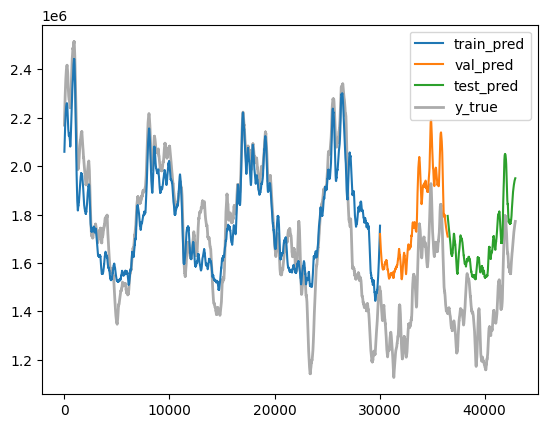

In [95]:
plt.plot(range(0, n_train), smooth_train, label="train_pred")
plt.plot(range(n_train, n_train+n_val), smooth_val, label="val_pred")
plt.plot(range(n_train+n_val, n_train+n_val+n_test), smooth_test, label="test_pred")

smooth_y_true = savgol_filter(y, window_length=500, polyorder=2)
plt.plot(smooth_y_true, label="y_true", color="black", linewidth=2, alpha=0.33, zorder=-1)

plt.legend()
plt.show()

### 3. Prognosemodell
Lag en enkel modell for å prognosere strømforbruk basert på værdata.

Si litt om:
- styrker og svakheter ved modellen
- hvor god modellen er (gjerne kvantitativ evaluering)

Den beste modellen var: K Nearest Neighbors!
* Styrker:
    * så å si ingen trenigs tid. (all logikk skjer under prediskjon)
    * Lett å tolke.
    * Fanger generelle trender.

* Svakheter:
    * Sen "prediction"
    * Modellen bruker (bare) værobservasjoner som input (ikke prognoser).
    * Modellen mangler data om tid på året, uken, og dagen, og må forstå dette ut fra været
    * spesielle hendelser fanges ikke opp av modellen (høytider, start og slutt av produksjon, endringer i lov verk, covid osv)